# 1. Setup

## 1.1. Import statements

In [1]:
%matplotlib inline

In [2]:
import os

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'backend:cudaMallocAsync'

print(os.environ.get('PYTORCH_CUDA_ALLOC_CONF'))

backend:cudaMallocAsync


In [3]:
import torch
import torch.nn as nn
import time
import gc
import matplotlib.pyplot as plt
from torchinfo import summary
from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader, random_split
from torch.amp import autocast, GradScaler
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder

## 1.2. Device configuration

In [4]:
def get_device() -> torch.device:
    """Get the best available device for PyTorch."""
    if torch.cuda.is_available():
        device = "cuda"

        # The flag below controls whether to allow TF32 on matmul.
        torch.backends.cuda.matmul.allow_tf32 = True
        # The flag below controls whether to allow TF32 on cuDNN.
        torch.backends.cudnn.allow_tf32 = True

        # Print GPU info
        print(f"Using CUDA device: {torch.cuda.get_device_name(0)}")
        
        # Set up GPU memory management
        memory_limit_mb = 4095.5  # Adjust as needed

        total_memory = torch.cuda.get_device_properties(0).total_memory

        memory_limit = memory_limit_mb * 1024 ** 2
        memory_fraction = memory_limit / total_memory

        torch.cuda.set_per_process_memory_fraction(memory_fraction, device=0)

        print(f"Set GPU memory fraction to {memory_fraction:.2%}")

        # Ensure memory is allocated
        torch.cuda.empty_cache()
    elif torch.backends.mps.is_available():
        device = "mps"
        print("Using Apple Silicon MPS device")
    else:
        device = "cpu"
        print("Using CPU device")
    
    return torch.device(device)

In [5]:
torch.set_float32_matmul_precision('high')
device = get_device()

Using CUDA device: NVIDIA GeForce RTX 3050 Ti Laptop GPU
Set GPU memory fraction to 100.00%


In [6]:
pin_memory = True if device.type == 'cuda' else False
pin_memory_device = 'cuda' if device.type == 'cuda' else ''

# 2. Load & transform data

## 2.1. Normalize the dataset

In [ ]:
# First, create transforms without normalization to calculate dataset statistics
initial_transforms = v2.Compose([
    v2.Resize((480, 270)),# changed from v1
    v2.Grayscale(num_output_channels=1),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

In [8]:
label_transforms = v2.Lambda(
    lambda y: torch.zeros(15, dtype=torch.float16).scatter_(dim=0, index=torch.tensor(y, dtype=torch.long), value=1)
)

In [9]:
# Create temporary dataset to calculate mean and std
temp_dataset = ImageFolder(root='../data/new_pool', transform=initial_transforms, target_transform=label_transforms)

temp_loader = DataLoader(temp_dataset, batch_size=32, shuffle=False, num_workers=6, pin_memory=pin_memory, pin_memory_device=pin_memory_device)

In [ ]:
calc_stats = True

if calc_stats:
    print(f"Computing dataset statistics using device: {device}")
    print(f"Number of images to process: {len(temp_dataset)}")

    channels_sum = torch.zeros(3, device=device)
    channels_sqrd_sum = torch.zeros(3, device=device)
    num_batches = 0
    start_time = time.time()

    for batch_idx, (data, _) in enumerate(tqdm(temp_loader, desc="Computing mean/std")):
        data = data.to(device, non_blocking=True)  # Add non_blocking=True
        with autocast(str(device)):
            channels_sum += torch.mean(data, dim=[0, 2, 3])
            channels_sqrd_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1
        
        if batch_idx % 10 == 0:
            batch_time = time.time() - start_time
            print(f"\nProcessed {batch_idx * temp_loader.batch_size} images in {batch_time:.2f}s")

    mean = channels_sum / num_batches
    std = torch.sqrt((channels_sqrd_sum / num_batches) - (mean ** 2))

    mean = mean.cpu().tolist()
    std = std.cpu().tolist()

    total_time = time.time() - start_time
    print(f"\nTotal processing time: {total_time:.2f} seconds")
    print(f"Dataset mean: {mean}")
    print(f"Dataset std: {std}")

    torch.cuda.empty_cache()
    
    # Release memory
    del temp_dataset, temp_loader, channels_sum, channels_sqrd_sum, data
    gc.collect()

    torch.cuda.empty_cache()
else:
    mean=[0.36145609617233276, 0.3521592915058136, 0.3483520746231079]
    std=[0.20100851356983185, 0.21270669996738434, 0.254261314868927]

## 2.2. Define transforms

In [11]:
train_transforms = v2.Compose([
    v2.Resize((480, 270)), # changed from v1
    v2.RandomVerticalFlip(p=0.2),
    v2.Grayscale(num_output_channels=3),
    v2.ColorJitter(
        brightness=0.1,
    ),
    v2.RandomAdjustSharpness(sharpness_factor=1.1, p=1.0),  # Subtle sharpness changes
    # Small perspective changes to simulate different card angles
    v2.RandomPerspective(
        distortion_scale=0.15,  # Keep perspective changes minimal
        p=0.2                   # Apply only 30% of the time
    ),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std)
])

In [12]:
val_transforms = v2.Compose([
    v2.Resize((480, 270)),
    v2.Grayscale(num_output_channels=3),
    v2.RandomAdjustSharpness(sharpness_factor=1.1, p=1.0),  # Subtle sharpness changes
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std),
])

# 3. Partition dataset

In [13]:
# Load the dataset with appropriate transforms
full_dataset = ImageFolder(root='../data/new_pool', transform=None)

In [ ]:
# Define split ratios
train_ratio = 0.75
val_ratio = 0.20
test_ratio = 0.05

# calculate lengths
total_size = len(full_dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

In [15]:
# Create train/val/test datasets with appropriate transforms
train_data, val_data, test_data = random_split(
    full_dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

In [16]:
# Directly override transforms
train_data.dataset.transform = train_transforms
train_data.dataset.target_transform = label_transforms

val_data.dataset.transform = val_transforms 
val_data.dataset.target_transform = label_transforms

In [17]:
# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=6, pin_memory=pin_memory, pin_memory_device=pin_memory_device)

val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=6, pin_memory=pin_memory, pin_memory_device=pin_memory_device)  

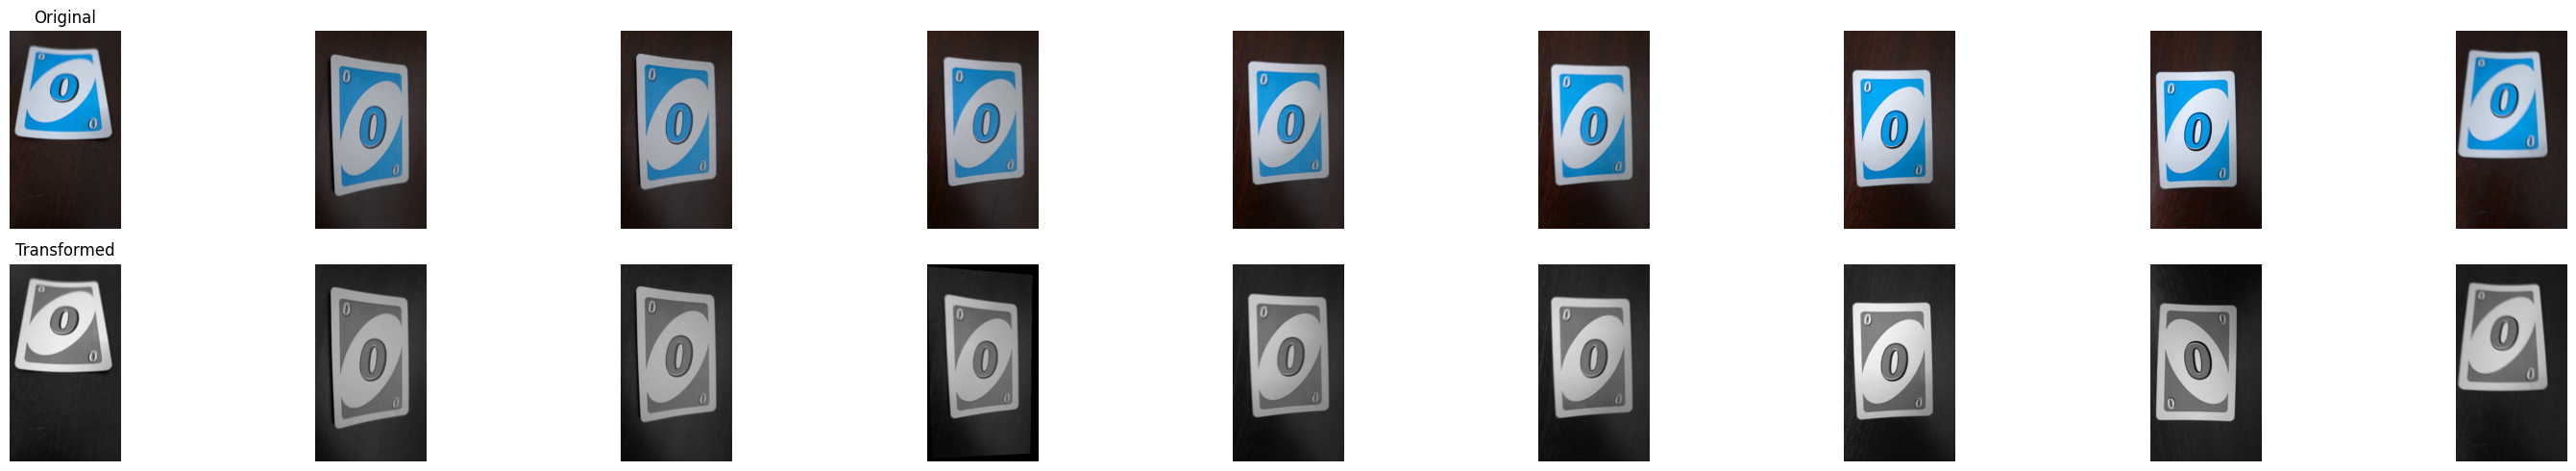

Random samples from dataset with augmentations:


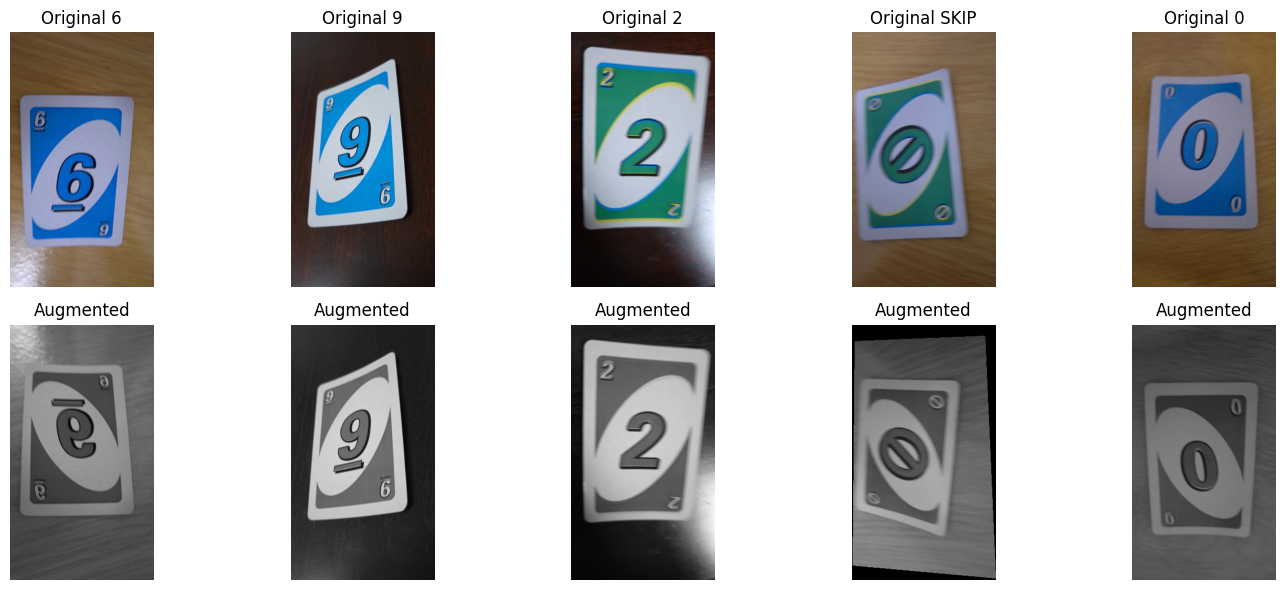


Multiple augmentations of a random 7 card:


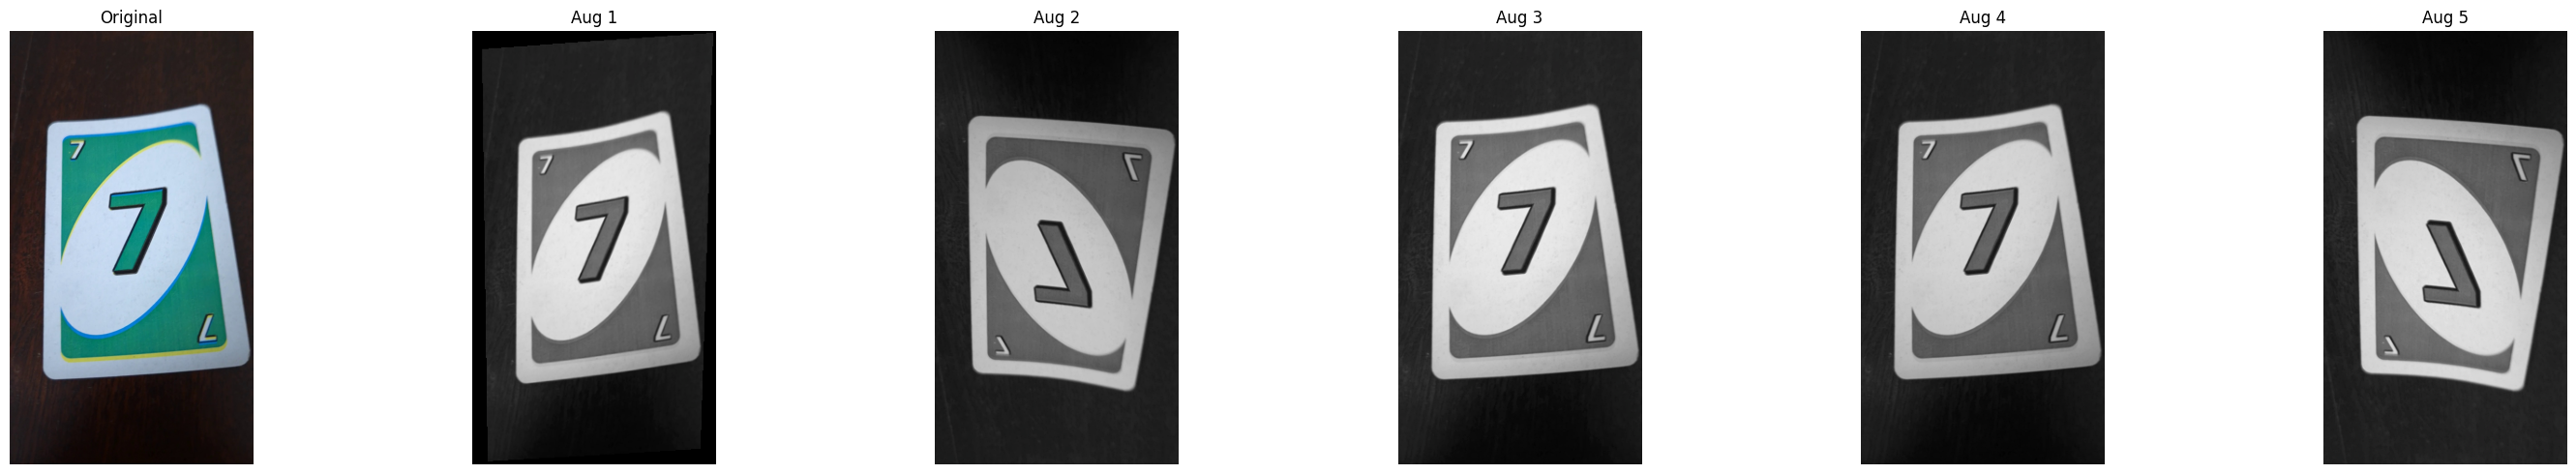

In [18]:
def show_transformed_images(dataset, num_images=9, cols=6):
    """Display original and transformed images side by side"""
    plt.figure(figsize=(30, 5))
    for i in range(num_images):
        # Get an image and its label
        img_path = dataset.samples[i][0]
        original_img = Image.open(img_path).convert('RGB')
        
        # Apply transforms multiple times to see variability
        transformed_img = train_transforms(original_img)
        
        # Convert tensor to image for display
        transformed_img = transformed_img.permute(1, 2, 0)  # Change from CxHxW to HxWxC
        transformed_img = transformed_img * torch.tensor(std) + torch.tensor(mean)  # Denormalize
        transformed_img = torch.clamp(transformed_img, 0, 1)  # Clamp values to valid range
        
        # Plot original and transformed
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_img)
        plt.axis('off')
        if i == 0:
            plt.title('Original')
            
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(transformed_img)
        plt.axis('off')
        if i == 0:
            plt.title('Transformed')
    
    plt.tight_layout()
    plt.show()
    
# Display sample images
show_transformed_images(full_dataset)

# Show multiple augmentations of same image
def show_multiple_augmentations(dataset, img_index=0, num_augments=5):
    """Show multiple augmentations of the same image"""
    plt.figure(figsize=(30, 5))
    
    # Get original image
    img_path = dataset.samples[img_index][0]
    original_img = Image.open(img_path).convert('RGB')
    
    # Show original
    plt.subplot(1, num_augments + 1, 1)
    plt.imshow(original_img)
    plt.axis('off')
    plt.title('Original')
    
    # Show different augmentations
    for i in range(num_augments):
        transformed_img = train_transforms(original_img)
        transformed_img = transformed_img.permute(1, 2, 0)
        transformed_img = transformed_img * torch.tensor(std) + torch.tensor(mean)
        transformed_img = torch.clamp(transformed_img, 0, 1)
        
        plt.subplot(1, num_augments + 1, i + 2)
        plt.imshow(transformed_img)
        plt.axis('off')
        plt.title(f'Aug {i+1}')
    
    plt.tight_layout()
    plt.show()

def show_random_augmentations(dataset, num_images=5):
    """Display random images before and after augmentation"""
    plt.figure(figsize=(15, 6))
    
    # Get random indices
    indices = torch.randperm(len(dataset))[:num_images]
    
    for idx, i in enumerate(indices):
        # Get an image and its label
        img_path = dataset.samples[i][0]
        original_img = Image.open(img_path).convert('RGB')
        
        # Apply transforms
        transformed_img = train_transforms(original_img)
        
        # Denormalize transformed image
        transformed_img = transformed_img.permute(1, 2, 0)
        transformed_img = transformed_img * torch.tensor(std) + torch.tensor(mean)
        transformed_img = torch.clamp(transformed_img, 0, 1)
        
        # Plot original
        plt.subplot(2, num_images, idx + 1)
        plt.imshow(original_img)
        plt.title(f'Original {dataset.classes[dataset.targets[i]]}')
        plt.axis('off')
        
        # Plot transformed
        plt.subplot(2, num_images, idx + 1 + num_images)
        plt.imshow(transformed_img)
        plt.title('Augmented')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Show random images and their augmentations
print("Random samples from dataset with augmentations:")
show_random_augmentations(full_dataset)

# Show multiple augmentations of the same random image
rand_idx = torch.randint(0, len(train_data), (1,)).item()
print(f"\nMultiple augmentations of a random {full_dataset.classes[full_dataset.targets[rand_idx]]} card:")
show_multiple_augmentations(full_dataset, img_index=rand_idx, num_augments=5)

# 4. Building the convolutional neural network

In [19]:
# Input shape constants (changed from v1)
IMG_WIDTH = 480 
IMG_HEIGHT = 270
IMG_CHANNELS = 3

In [20]:
class UnoSymbolClassifier(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.conv_block1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )

        self.conv_block2 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 16, 3, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )

        self.conv_block3 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(16, 32, 3, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2) 
        )

        self.conv_block4 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(32, 64, 3, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((9, 16))

        self.flatten = nn.Flatten()        

        self.fc = nn.Sequential(
            nn.Linear(64 * 9 * 16, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(16, 15)  # Assuming 15 classes
        )

    def forward(self, x) -> torch.utils.data.Dataset:
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.global_avg_pool(x)
        x = self.flatten(x)
        x = self.fc(x)

        return x

## 4.2. Create the model

In [21]:
model = UnoSymbolClassifier()
model.to("cpu")
model = torch.compile(model, backend="inductor")

In [22]:
summary(model, input_size=(32, IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH))

Layer (type:depth-idx)                   Output Shape              Param #
OptimizedModule                          [32, 15]                  --
├─UnoSymbolClassifier: 1-1               [32, 15]                  --
│    └─Sequential: 2-1                   [32, 8, 270, 480]         --
│    │    └─ReflectionPad2d: 3-1         [32, 3, 272, 482]         --
│    │    └─Conv2d: 3-2                  [32, 8, 270, 480]         224
│    │    └─BatchNorm2d: 3-3             [32, 8, 270, 480]         16
│    │    └─ReLU: 3-4                    [32, 8, 270, 480]         --
│    │    └─ReflectionPad2d: 3-5         [32, 8, 272, 482]         --
│    │    └─Conv2d: 3-6                  [32, 8, 270, 480]         584
│    │    └─BatchNorm2d: 3-7             [32, 8, 270, 480]         16
│    │    └─ReLU: 3-8                    [32, 8, 270, 480]         --
│    └─Sequential: 2-2                   [32, 16, 270, 480]        --
│    │    └─ReflectionPad2d: 3-9         [32, 8, 272, 482]         --
│    │    └─C

In [23]:
model.to(device, non_blocking=True)

torch.cuda.empty_cache()

# 5. Optimising model parameters

## 5.1. Learning parameters

In [24]:
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 2.5e-3
EPOCHS = 100

## 5.2. Optimizer & cost function

In [25]:
loss_fn = nn.CrossEntropyLoss()

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, fused=True)

In [27]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=4)

# 6. Training the model

## 6.1. Define train function

In [28]:
def train_loop(dataloader, model, loss_fn, optimizer):
    scaler = GradScaler()
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()

    training_loss = 0.0
    correct = 0
    total = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)  # Move data to device

        optimizer.zero_grad()

        with autocast(str(device)):
            # Compute prediction and loss
            pred = model(X)
            loss = loss_fn(pred, y)

        # Backpropagation
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        training_loss += loss.item() * X.size(0)
        correct += (pred.argmax(1) == y.argmax(1)).type(torch.float32).sum().item()
        total += y.size(0)

        if batch % 100 == 0:
            loss_item = loss.item()
            current = batch * len(X)
            print(f"loss: {loss_item:>7f}  [{current:>5d}/{size:>5d}]")

    avg_loss = training_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

## 6.2. Define validate & test function

In [29]:
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)  # Move data to device

            with autocast(str(device)):
                pred = model(X)
                loss = loss_fn(pred, y)

            test_loss += loss.item() * X.size(0)
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float32).sum().item()
            total += y.size(0)

    avg_loss = test_loss / total
    accuracy = correct / total
    print(f"Avg loss: {avg_loss:>8f}, Accuracy: {(100*accuracy):>0.1f}%\n")

    return avg_loss, accuracy

## 6.3. Define overfitting function

In [30]:
def check_overfitting(train_loss, val_loss, train_acc, val_acc, threshold=0.1):
    loss_gap = abs(train_loss - val_loss)
    acc_gap = abs(train_acc - val_acc)
    
    is_overfitting = (loss_gap > threshold) and (train_acc > val_acc + threshold)
    
    if is_overfitting:
        print(f"Warning: Possible overfitting detected")
        print(f"Loss gap: {loss_gap:.4f}, Accuracy gap: {acc_gap:.4f}")
    
    return is_overfitting

## 6.4. Training loop

In [31]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
epoch_times = []

best_val_loss = float('inf')
best_model_metrics = None
stopped_early = False
is_overfitting = 0
patience = 10  # Number of epochs with no improvement after which training will be stopped
total_start_time = time.time()

In [32]:
torch.cuda.empty_cache()

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}\n-------------------------------")
    epoch_start_time = time.time()

    train_loss, train_accuracy = train_loop(train_loader, model, loss_fn, optimizer)

    scheduler.step(train_loss)  
        
    val_loss, val_accuracy = test_loop(val_loader, model, loss_fn)

    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1} completed in {epoch_time:.2f} seconds")
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}\n")

    # Increment overfitting counter if overfitting detected
    if check_overfitting(train_loss, val_loss, train_accuracy, val_accuracy):
        is_overfitting += 1
    else:
        is_overfitting = 0

    # Check all conditions
    accuracy_gap = abs(train_accuracy - val_accuracy)
    conditions_met = (
        train_loss > 0.13 and
        val_loss > 0.13 and
        train_accuracy < 0.99 and
        val_accuracy < 0.99 and
        accuracy_gap < 0.03
    )

    # Save model if conditions are met and validation loss improved
    if conditions_met and val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_metrics = {
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_accuracy': train_accuracy,
            'val_accuracy': val_accuracy
        }
        torch.save(model.state_dict(), '../data/models/best_symbol_classifier.pth')

    # Stop if overfitting persists for multiple epochs
    if is_overfitting >= patience:
        print(f"Early stopping triggered due to persistent overfitting.")
        stopped_early = True
        break

total_training_time = time.time() - total_start_time

# Save both models
torch.save(model, '../data/models/full_symbol_classifier.pth')

if best_model_metrics:
    print("\nBest model saved with metrics:")
    for key, value in best_model_metrics.items():
        print(f"{key}: {value}")

print(f"\nTraining complete in {total_training_time:.2f} seconds")
print("\n-------------------------------\nDone!")

Epoch 1
-------------------------------
loss: 2.756927  [    0/ 4128]
loss: 2.777679  [ 3200/ 4128]
Avg loss: 2.692158, Accuracy: 8.1%

Epoch 1 completed in 85.94 seconds
Training Loss: 2.7718, Training Accuracy: 0.0841
Validation Loss: 2.6922, Validation Accuracy: 0.0808

Epoch 2
-------------------------------
loss: 2.803406  [    0/ 4128]
loss: 2.757935  [ 3200/ 4128]
Avg loss: 2.681696, Accuracy: 8.9%

Epoch 2 completed in 34.78 seconds
Training Loss: 2.7543, Training Accuracy: 0.0841
Validation Loss: 2.6817, Validation Accuracy: 0.0889

Epoch 3
-------------------------------
loss: 2.731628  [    0/ 4128]
loss: 2.752319  [ 3200/ 4128]
Avg loss: 2.678409, Accuracy: 9.0%

Epoch 3 completed in 34.76 seconds
Training Loss: 2.7405, Training Accuracy: 0.0833
Validation Loss: 2.6784, Validation Accuracy: 0.0899

Epoch 4
-------------------------------
loss: 2.673767  [    0/ 4128]
loss: 2.672699  [ 3200/ 4128]
Avg loss: 2.663097, Accuracy: 11.7%

Epoch 4 completed in 34.45 seconds
Traini

# 7. Plot model metrics

In [33]:
epochs_range = range(1, len(train_losses) + 1)

## 7.1. Loss graph

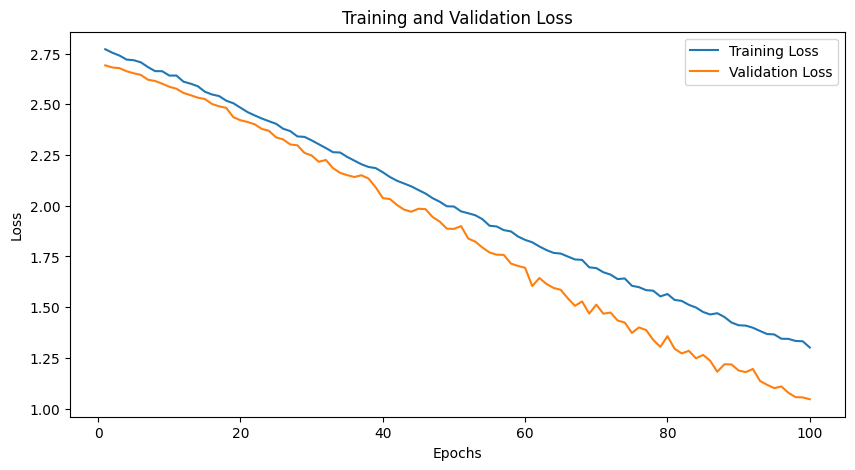

In [34]:
# Plot Losses
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## 7.2. Accuracy graph

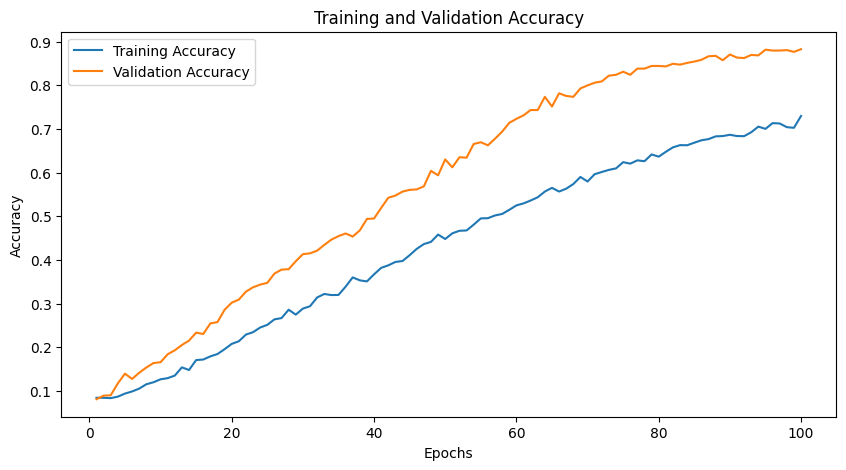

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## 7.3. Epoch duration graph

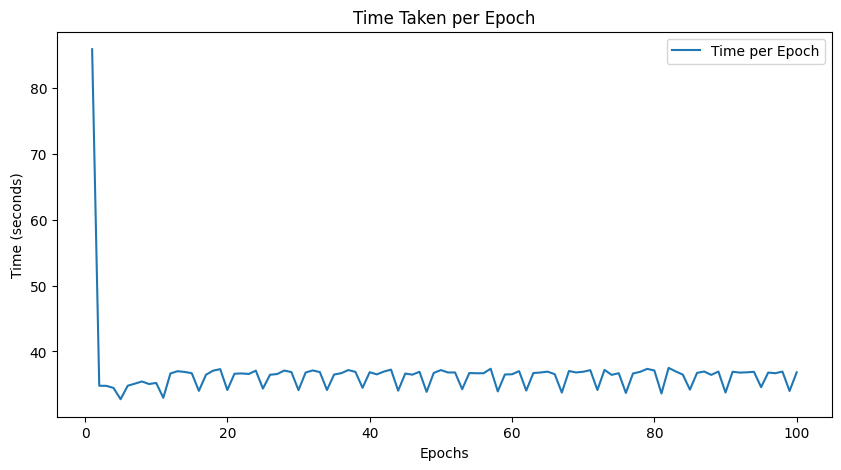

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, epoch_times, label='Time per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Time (seconds)')
plt.title('Time Taken per Epoch')
plt.legend()
plt.show()

# 8. Test the model

## 8.1. Create & load model

In [37]:
torch.cuda.empty_cache()

model = UnoSymbolClassifier()
model.to(device, non_blocking=True)
model = torch.compile(model, backend="inductor")

In [39]:
stopped_early = False

# Load the best model (if saved during early stopping)
if stopped_early:
    model.load_state_dict(torch.load('../data/models/best_symbol_classifier.pth'))
else:
    model = torch.load('../data/models/final_model.pth')

/tmp/ipykernel_665188/854941723.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('../data/models/final_model.pth')


## 8.2. Test model on the dataset

In [40]:
test_data.dataset.transform = val_transforms

test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=4, pin_memory=False)

In [41]:
model.eval()

print("Test Results on the Test Set:")
test_loop(test_loader, model, loss_fn)

Test Results on the Test Set:
Avg loss: 1.115715, Accuracy: 87.0%



(1.1157147501416775, 0.8704663212435233)

## 8.3. Test model on own image

In [83]:
image_transform = v2.Compose([
    v2.Grayscale(num_output_channels=3),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

In [104]:
# Load and preprocess the image
image_path = '../data/test_images/green_draw2.jpg' 
original_image = Image.open(image_path).convert('RGB')

input_tensor = image_transform(original_image)
input_tensor = input_tensor.unsqueeze(0)  # Add batch dimension
input_tensor = input_tensor.to(device, non_blocking=True)

Transformed image shape: (3000, 4000, 3)
Are all channels identical? True


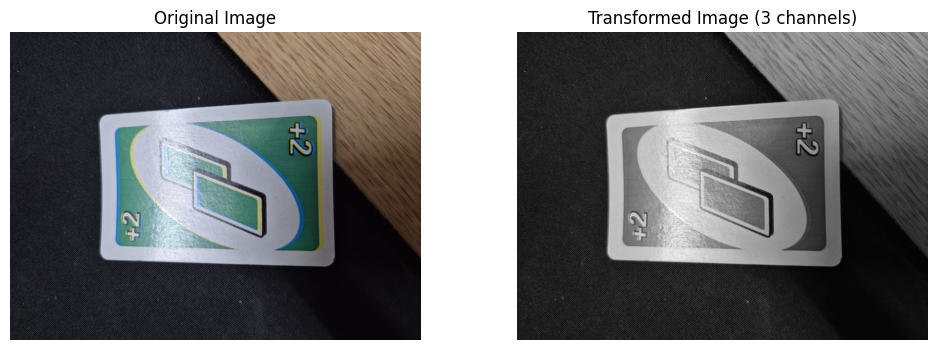

In [105]:
import numpy as np

# Display original image
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

# Display transformed image
transformed_image = input_tensor[0].cpu().permute(1, 2, 0).numpy()
plt.subplot(1, 2, 2)
plt.imshow(transformed_image)
plt.title('Transformed Image (3 channels)')
plt.axis('off')

# Print channel information
print(f"Transformed image shape: {transformed_image.shape}")
print(f"Are all channels identical? {np.allclose(transformed_image[:,:,0], transformed_image[:,:,1])}")

plt.show()

In [106]:
# Make prediction
with torch.no_grad():
    with autocast(str(device)):  # Add autocast here for consistent mixed precision inference
        output = model(input_tensor)
    predicted_class = output.argmax(dim=1).item()

In [107]:
# Get class names
print(predicted_class)
class_names = full_dataset.classes
print(class_names)
predicted_label = class_names[predicted_class]
print(f"Predicted class: {predicted_label}")

7
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'DRAW2', 'DRAW4', 'REVERSE', 'SKIP', 'WILD']
Predicted class: 7
